<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%203%20/%20Tugas%20/%20PyTorch_SVHN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load SVHN dataset
train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 182M/182M [00:01<00:00, 91.8MB/s]
100%|██████████| 64.3M/64.3M [00:08<00:00, 7.41MB/s]


In [ ]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(self.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(self.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(self.relu(self.batchnorm4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# Initialize model, loss function, optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training
train_acc_history, test_acc_history, train_loss_history, test_loss_history = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Testing
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    test_acc = correct / total
    test_loss = running_loss / len(test_loader)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)

    scheduler.step(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/20], Train Acc: 0.7236, Test Acc: 0.8767, Train Loss: 0.8369, Test Loss: 0.4130
Epoch [2/20], Train Acc: 0.8895, Test Acc: 0.8855, Train Loss: 0.3803, Test Loss: 0.3838
Epoch [3/20], Train Acc: 0.9114, Test Acc: 0.9066, Train Loss: 0.3093, Test Loss: 0.3212
Epoch [4/20], Train Acc: 0.9248, Test Acc: 0.9104, Train Loss: 0.2636, Test Loss: 0.3038
Epoch [5/20], Train Acc: 0.9349, Test Acc: 0.9215, Train Loss: 0.2301, Test Loss: 0.2844
Epoch [6/20], Train Acc: 0.9424, Test Acc: 0.9182, Train Loss: 0.2037, Test Loss: 0.2894
Epoch [7/20], Train Acc: 0.9502, Test Acc: 0.9286, Train Loss: 0.1752, Test Loss: 0.2685
Epoch [8/20], Train Acc: 0.9546, Test Acc: 0.9228, Train Loss: 0.1577, Test Loss: 0.2867
Epoch [9/20], Train Acc: 0.9593, Test Acc: 0.9303, Train Loss: 0.1420, Test Loss: 0.2836
Epoch [10/20], Train Acc: 0.9645, Test Acc: 0.9302, Train Loss: 0.1221, Test Loss: 0.2876
Epoch [11/20], Train Acc: 0.9685, Test Acc: 0.9281, Train Loss: 0.1084, Test Loss: 0.2977
Epoch [12/20], Trai

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1_squared = f1_score(y_true, y_pred, average='macro') ** 2
auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

print(f'Final Accuracy: {accuracy:.4f}')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Squared: {f1_squared:.4f}')
print(f'Final AUC: {auc:.4f}')

Final Accuracy: 0.9315
Final Precision: 0.9289
Final Recall: 0.9248
Final F1 Squared: 0.8587
Final AUC: 0.9939


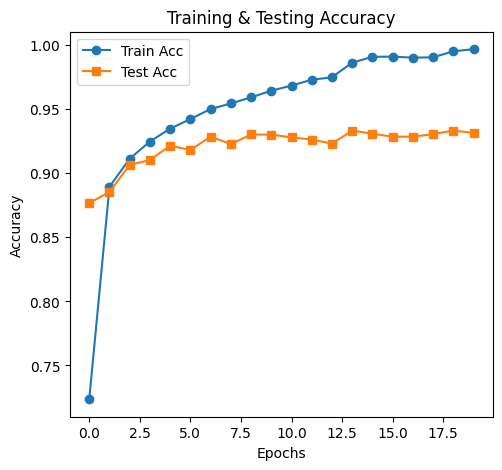

In [ ]:
# Plot Accuracy & Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc_history, label="Train Acc", marker='o')
plt.plot(test_acc_history, label="Test Acc", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Testing Accuracy")
plt.legend()
plt.show()

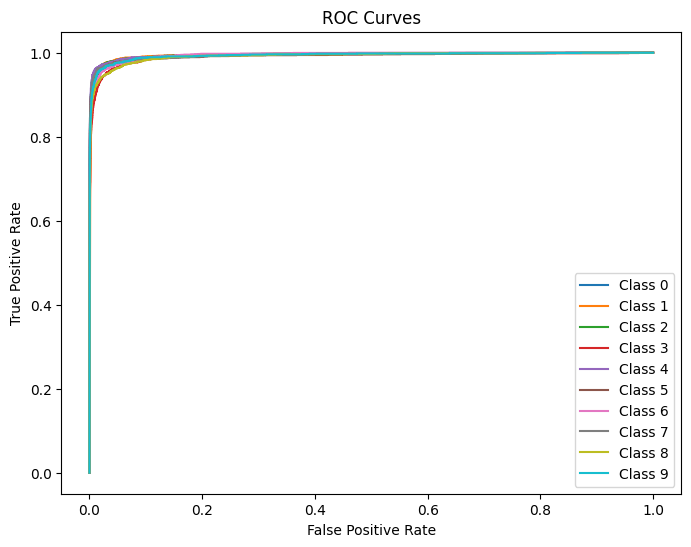

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
for i in range(10):
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_scores)[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Evaluasi Model CNN - CIFAR-10 Dataset

## Persamaan Matematika Evaluasi Model

Metrik evaluasi yang digunakan untuk menilai performa model CNN pada dataset CIFAR-10.

---

### 1. **Accuracy**

Mengukur seberapa banyak prediksi yang benar.


$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$


Keterangan:
- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

---

### 2. **Precision**

Mengukur seberapa tepat prediksi positif model.

$\text{Precision} = \frac{TP}{TP + FP}$

---

### 3. **Recall**

Mengukur seberapa banyak data positif yang berhasil diprediksi model.

$\text{Recall} = \frac{TP}{TP + FN}$

---

### 4. **F1-Score**

Rata-rata harmonis dari Precision dan Recall untuk menyeimbangkan keduanya.

$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

---

### 5. **AUC (Area Under Curve)**

Mengukur kemampuan model untuk membedakan antara kelas positif dan negatif. Nilai AUC berada di antara 0 dan 1. Semakin tinggi nilainya, semakin baik model dalam membedakan antar kelas.

$$
\text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR}) \, d\text{FPR}
$$

---

### 6. **ROC Curve (Receiver Operating Characteristic Curve)**

Kurva ROC menggambarkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR):

\[
$\text{TPR} = \frac{TP}{TP + FN}$
\]

\[
$\text{FPR} = \frac{FP}{FP + TN}$
\]